# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [230]:
n_samples = 50000

In [231]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None, frontier=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    if frontier is not None:
        plt.scatter(frontier['volatility'], frontier['return'], color='red', marker='.', s=300)

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [232]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

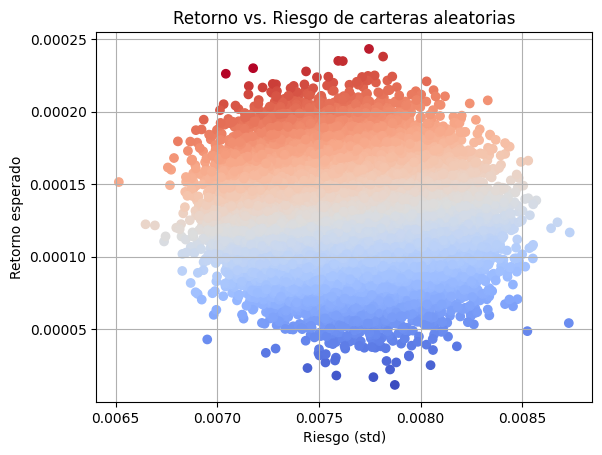

In [233]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset34', 'asset20', 'asset22', 'asset41', 'asset14', 'asset15', 'asset2', 'asset40', 'asset21', 'asset27'}
[33, 19, 21, 40, 13, 14, 1, 39, 20, 26]


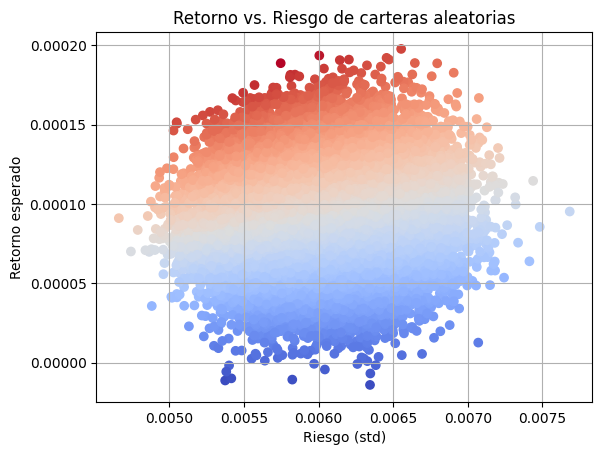

In [234]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 5):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.9) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



7.936507936507937e-05
8.565429913586974e-05
9.194351890666011e-05
9.823273867745047e-05
0.00010452195844824084
0.00011081117821903121
0.00011710039798982159
0.00012338961776061196
0.00012967883753140232
0.0001359680573021927
0.00014225727707298306
0.00014854649684377342
0.0001548357166145638
0.0001611249363853542
0.00016741415615614455
0.0001737033759269349
0.00017999259569772527
0.00018628181546851566
0.00019257103523930604
0.0001988602550100964
0.00020514947478088676
0.00021143869455167715
0.0002177279143224675
0.00022401713409325787
0.00023030635386404825
0.0002365955736348386
0.000242884793405629
0.0002491740131764194
0.00025546323294720974
0.0002617524527180001
0.00026804167248879046
0.0002743308922595808
0.0002806201120303712
0.00028690933180116154
0.00029319855157195195
0.0002994877713427423
0.0003057769911135327
0.0003120662108843231
0.00031835543065511344
0.0003246446504259038
0.00033093387019669416
0.0003372230899674845
0.00034351230973827493
0.0003498015295090653
0.000356090

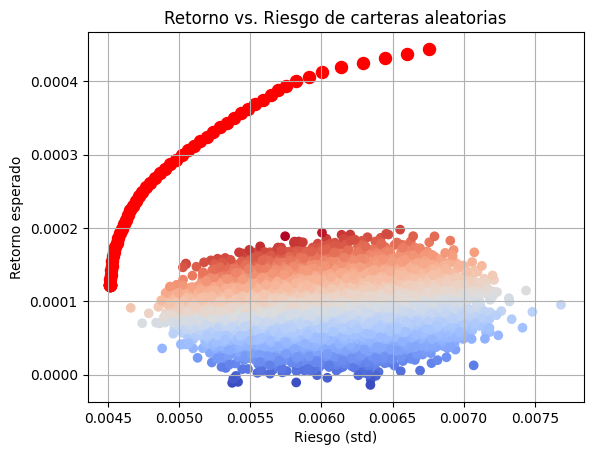

In [235]:
import cvxpy as cp

# Los assets con correlacion inferior al 80% y curtosis <= 5 y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
# 2% se refiere a anual
fixed_income_return = 0.02 / 252
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (fixed_income_return))

# CVXPY
target_return = cp.Parameter()
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov.values)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 4/n_assets, # forzar diversificacion
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0, # Evitamos dar peso a los activos muy relacionados o con curtosis alta
    portfolio_returns >= target_return # Minimo de retorno esperado
]

results = []
problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)

for r in np.linspace(fixed_income_return, returns_means.max(), 100):
    print(r)
    target_return.value = r
    problem.solve(solver=cp.OSQP)

    if best_weights.value is not None:
        ret = portfolio_returns.value
        vol = np.sqrt(portfolio_variance.value)
        sharpe_ratio = (ret - fixed_income_return) / vol if vol > 0 else 0
        row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])
        results.append(row)

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)

best_sharpe = portfolio_results.iloc[0]
best_sharpe_weights = best_sharpe[3:]

plot_sharpe(returns, mask, frontier=portfolio_results[['return', 'volatility']])


In [236]:
portfolio_results

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
53,0.000413,0.006008,0.055483,-1.005548e-05,5.384047e-09,-4.792057e-09,0.078434,0.004426,0.078436,-1.386393e-05,...,0.078433,-7.733790e-06,3.297031e-02,-0.000011,0.078432,-6.685684e-06,-7.234039e-06,-1.736969e-05,-0.000008,0.099996
54,0.000419,0.006138,0.055327,-1.111527e-05,3.563029e-09,-1.481154e-06,0.078432,-0.000003,0.078434,-1.466748e-05,...,0.078432,-9.184645e-06,4.214347e-02,-0.000012,0.029562,-8.144999e-06,-8.148219e-06,-1.794039e-05,-0.000009,0.099995
52,0.000406,0.005911,0.055326,-1.200490e-05,4.079617e-09,-1.121743e-06,0.078433,0.034512,0.078435,-1.455046e-05,...,0.078432,-8.506687e-06,1.892278e-02,-0.000011,0.078431,-8.646721e-06,-8.109246e-06,-1.745592e-05,-0.000009,0.099996
51,0.000400,0.005825,0.055063,-1.216703e-05,4.134712e-09,-1.136893e-06,0.078433,0.064040,0.078435,-1.474697e-05,...,0.078432,-8.621570e-06,1.390551e-02,-0.000011,0.078431,-8.763495e-06,-8.218762e-06,-1.769167e-05,-0.000009,0.099996
55,0.000425,0.006291,0.054983,-1.334603e-05,3.841590e-09,-8.483615e-07,0.078432,-0.000001,0.078436,-1.589629e-05,...,0.078434,-8.528436e-06,4.639064e-02,-0.000008,0.037809,-1.128270e-05,-9.045880e-06,-1.346895e-05,-0.000006,0.079364
56,0.000432,0.006445,0.054646,-1.297806e-05,3.735672e-09,-8.249708e-07,0.078432,-0.000001,0.078436,-1.545800e-05,...,0.078434,-8.293294e-06,5.061090e-02,-0.000007,0.046291,-1.097162e-05,-8.796471e-06,-1.309759e-05,-0.000006,0.058683
50,0.000394,0.005755,0.054636,-1.157564e-05,3.116874e-09,-8.508856e-07,0.064419,0.078430,0.078435,-1.364165e-05,...,0.078433,-7.313685e-06,1.398440e-02,-0.000005,0.078431,-9.337034e-06,-7.441775e-06,-7.786403e-06,-0.000005,0.099999
57,0.000438,0.006600,0.054319,-1.296992e-05,3.733330e-09,-8.244537e-07,0.078432,-0.000001,0.078436,-1.544831e-05,...,0.078434,-8.288095e-06,5.482902e-02,-0.000007,0.054770,-1.096474e-05,-8.790957e-06,-1.308938e-05,-0.000006,0.038014
49,0.000388,0.005698,0.054079,-8.889686e-06,2.393650e-09,-6.534500e-07,0.062827,0.078430,0.078434,-1.047631e-05,...,0.078433,-5.616654e-06,1.302540e-02,-0.000004,0.078431,-7.170516e-06,-5.715023e-06,-5.979686e-06,-0.000004,0.099999
58,0.000444,0.006755,0.053999,-1.296974e-05,3.733278e-09,-8.244423e-07,0.078432,-0.000001,0.078436,-1.544810e-05,...,0.078434,-8.287980e-06,5.904709e-02,-0.000007,0.063249,-1.096459e-05,-8.790835e-06,-1.308919e-05,-0.000006,0.017345


In [237]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [238]:
# rounded_weights = round_weights(best_sharpe_weights.tolist())
rounded_weights = np.array([round(w, 3) if abs(w) > 1e-4 else 0.0 for w in best_sharpe_weights])
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(len(rounded_weights[rounded_weights > 0]))

['0', '0', '0', '0.078', '0.004', '0.078', '0', '0.078', '0', '0', '0', '0', '0.078', '0', '0', '0', '0', '0.078', '0', '0', '0', '0', '0.078', '0', '0', '0', '0', '0.078', '0', '0', '0', '0', '0', '0', '0.078', '0.078', '0', '0', '0', '0', '0', '0.078', '0', '0.033', '0', '0.078', '0', '0', '0', '0', '0.1']
14


In [239]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.02/252

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.006392654457832696


In [240]:
import numpy as np

# 1. Calcula los retornos diarios de tu cartera
portfolio_daily_returns = returns @ rounded_weights[:-1] + (rounded_weights[-1] * (0.02/252))

# 2. Calcula el valor acumulado de la inversión (empezando desde 1)
wealth_index = (1 + portfolio_daily_returns).cumprod()

# 3. Calcula el pico máximo acumulado en cada momento
previous_peaks = wealth_index.cummax()

# 4. Calcula los drawdowns
drawdowns = (wealth_index - previous_peaks) / previous_peaks

# 5. El Max Drawdown es el valor mínimo (la caída más profunda)
mdd = drawdowns.min()

print(f"Max Drawdown: {mdd * 100:.2f}%")

Max Drawdown: -13.71%
